# Import learning data

In [21]:
import pandas as pd

training_data_path = "../learning_data/data/win_rate/river/50000-data-1000-simulation-2-players-win-rate-data.csv"
test_data_path = "../learning_data/data/win_rate/river/10000-data-1000-simulation-2-players-win-rate-data.csv"
train_df = pd.read_csv(training_data_path)
test_df = pd.read_csv(test_data_path)

# About learning data

In [22]:
print train_df.shape, test_df.shape

(50000, 15) (10000, 15)


In [23]:
train_df.head()

,hole1,hole2,community1,community2,community3,community4,community5,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id,community5_id
0,S2,C8,C5,C9,DA,SA,S5,0.812,41,8,5,9,14,40,44
1,CA,D2,DJ,D6,H8,SK,CJ,0.516,1,15,24,19,34,52,11
2,S6,S8,SA,C9,HA,H6,C8,0.555,45,47,40,9,27,32,8
3,CK,SQ,C6,ST,SK,HA,C5,0.794,13,51,6,49,52,27,5
4,SQ,H5,ST,S9,SA,D9,H9,0.600,51,31,49,48,40,22,35


In [24]:
train_df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id,community5_id
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000
mean,0.586767,26.365540,26.421840,26.42548,26.54252,26.529120,26.579660,26.41158
std,0.263906,14.997504,14.957672,15.00689,14.99553,15.036352,14.962419,14.98069
min,0.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000
25%,0.457000,13.000000,13.000000,13.00000,14.00000,13.000000,14.000000,13.00000
50%,0.568000,26.000000,26.000000,26.00000,26.00000,27.000000,27.000000,26.00000
75%,0.814000,39.000000,39.000000,40.00000,40.00000,40.000000,40.000000,39.00000
max,1.000000,52.000000,52.000000,52.00000,52.00000,52.000000,52.000000,52.00000


In [25]:
test_df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id,community5_id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.584548,26.785300,26.192400,26.672400,26.400100,26.506900,26.501400,26.665500
std,0.264149,14.959572,15.023706,14.896425,15.025145,14.938101,15.103715,14.998703
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.456000,14.000000,13.000000,14.000000,13.000000,14.000000,13.000000,14.000000
50%,0.565000,27.000000,26.000000,27.000000,26.000000,26.000000,27.000000,27.000000
75%,0.811000,40.000000,39.000000,40.000000,39.000000,39.000000,40.000000,40.000000
max,1.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000


# Data Processing

## card id -> 1-hot vector

In [26]:
import numpy as np

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
fetch_hole = lambda row: [row[key] for key in ['hole1_id', 'hole2_id']]
fetch_community = lambda row: [row[key] for key in ['community1_id', 'community2_id', 'community3_id', 'community4_id', 'community5_id']]

train_hole_one_hot = train_df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
train_community_one_hot = train_df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
train_df["onehot"] = train_hole_one_hot + train_community_one_hot

test_hole_one_hot = test_df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
test_community_one_hot = test_df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
test_df["onehot"] = test_hole_one_hot + test_community_one_hot

## Format data (pandas.df -> numpy.ndarray)

In [27]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
test_x, test_y = [to_ndarray(array) for array in [test_df["onehot"].values, test_df["win_rate"].values]]
print "shape of training data => x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of test data => x: %s, y: %s" % (test_x.shape, test_y.shape)

shape of training data => x: (50000, 104), y: (50000,)
shape of test data => x: (10000, 104), y: (10000,)


# Create model

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=104))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

# Train model

In [29]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=1000, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

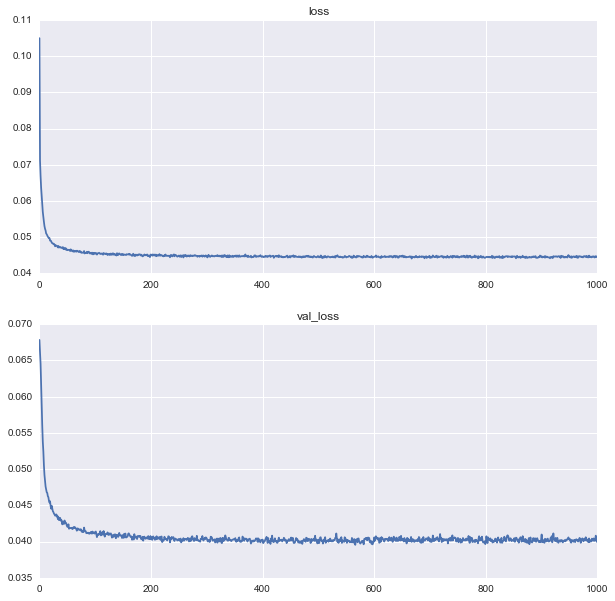

In [30]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 1, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [32]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, test_x, test_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on test data = {score}'.format(score=mean_squared_error(model.predict(test_x), test_y))

In [33]:
print_model_performance(model, train_x, train_y, test_x, test_y)

MSE on training data = 0.0355516544872
MSE on test data = 0.0396162555858


## See model prediction on sample data

In [34]:
from pypokerengine.engine.card import Card
C, D, H, S = Card.CLUB, Card.DIAMOND, Card.HEART, Card.SPADE

test_case = [
    [(11, H), (7, S), (12, H), (6, S), (1, H), (10, H), (13, H), 1.0],
    [(1, S), (4, H), (2, S), (4, S), (4, D), (1, H), (5, H), 0.993],
    [(8, D), (11, C), (3, S), (6, H), (10, C), (5, C), (4, D), 0.018],
    [(2, D), (13, S), (9, D), (5, C), (5, D), (1, H), (4, H), 0.501]
]

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
to_id = lambda card: card.to_id()

for card1, card2, card3, card4, card5, card6, card7, expected in test_case:
    cards = [Card(rank=rank, suit=suit) for rank, suit in [card1, card2, card3, card4, card5, card6, card7]]
    hole = cards[:2]
    community = cards[2:]
    hole_onehot = gen_one_hot(map(to_id, hole))
    community_onehot = gen_one_hot(map(to_id, community))
    x = hole_onehot + community_onehot
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s], COMMUNITY = [%s, %s, %s, %s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole) + map(str, community) + [y , expected])

HOLE = [HJ, S7], COMMUNITY = [HQ, S6, HA, HT, HK] => win_rate = { prediction=0.504224, expected=1.000000 }
HOLE = [SA, H4], COMMUNITY = [S2, S4, D4, HA, H5] => win_rate = { prediction=0.952135, expected=0.993000 }
HOLE = [D8, CJ], COMMUNITY = [S3, H6, CT, C5, D4] => win_rate = { prediction=0.507386, expected=0.018000 }
HOLE = [D2, SK], COMMUNITY = [D9, C5, D5, HA, H4] => win_rate = { prediction=0.478657, expected=0.501000 }
